# Определение возраста покупателей

**Описание проекта**
Сетевому супермаркету «Хлеб-Соль» требуется система компьютерного зрения для обработки фотографий покупателей. С помощью фотофиксации в прикассовой зоне нужно определять возраста клиентов, чтобы:  
1) Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;  
2) Контролировать добросовестность кассиров при продаже алкоголя.  
Нужно построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста и максимально допустима погрешность MAE:7, чтобы заказчик мог понять продолжать с нами работу или нет.   

## Исследовательский анализ данных

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf  
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
try:
    labels = pd.read_csv('/datasets/faces/labels.csv')
except:
    labels = pd.read_csv()

In [4]:
# функция для вывода основной информации о данных
def data_research1(data):
    display(data.head())
    print()
    data.info()
    print()
    print('Пропуски:', data.isna().sum().sum(), 'это {:.2%} от всех данных.'
          .format(data.isna().sum().sum() / (data.shape[0] * data.shape[1])))
    print()
    print('Процент (%) пропусков в каждой категории данных.')
    display((data.isna().sum() / data.shape[0]) * 100)
    print()
    print('Явные дубликаты:', data.duplicated().sum(), 'это {:.2%} от всех данных.'
          .format(data.duplicated().sum() / data.shape[0]))


In [5]:
data_research1(labels)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB

Пропуски: 0 это 0.00% от всех данных.

Процент (%) пропусков в каждой категории данных.


file_name    0.0
real_age     0.0
dtype: float64


Явные дубликаты: 0 это 0.00% от всех данных.


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


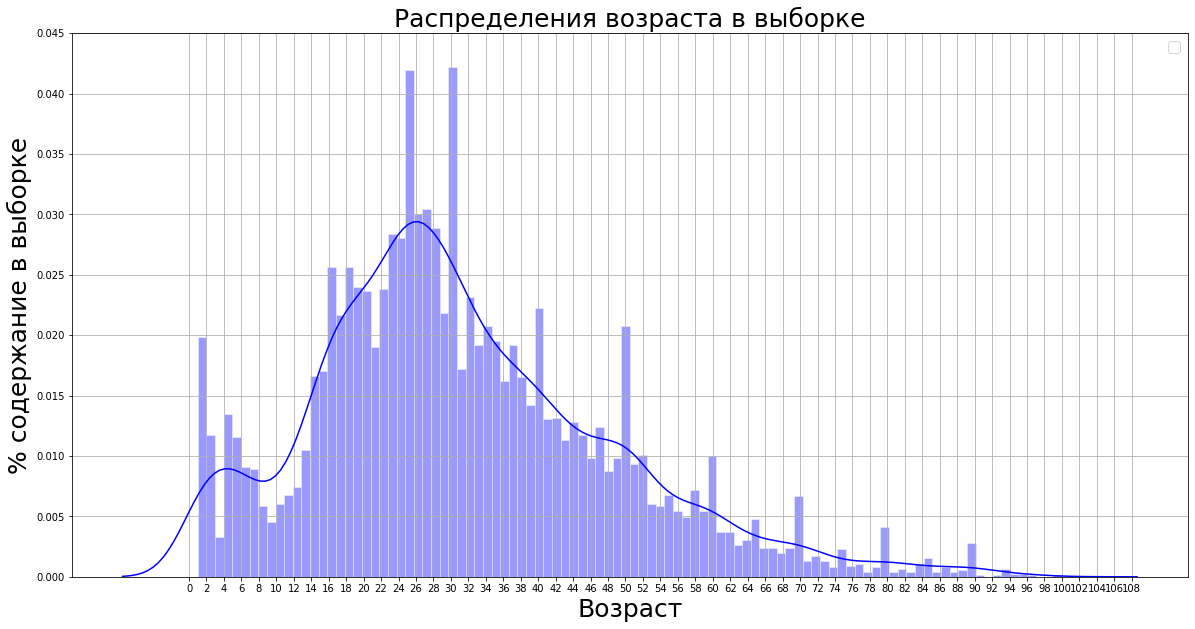

In [6]:
# строим график распределения частиц 
plt.figure(figsize=(20, 10))
# выводим данные
sns.distplot(labels['real_age'], color='blue',
             hist_kws={"edgecolor": 'white'}, bins = 100)
# задаем параметры таблицы
plt.title('Распределения возраста в выборке',fontsize=25)
plt.xlabel('Возраст',fontsize=25)
plt.ylabel('% содержание в выборке',fontsize=25)
plt.legend(fontsize=15)
plt.grid()
plt.xticks(np.arange(0, 110, 2))
plt.yticks(np.arange(0, 0.050, 0.005))
plt.show()

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


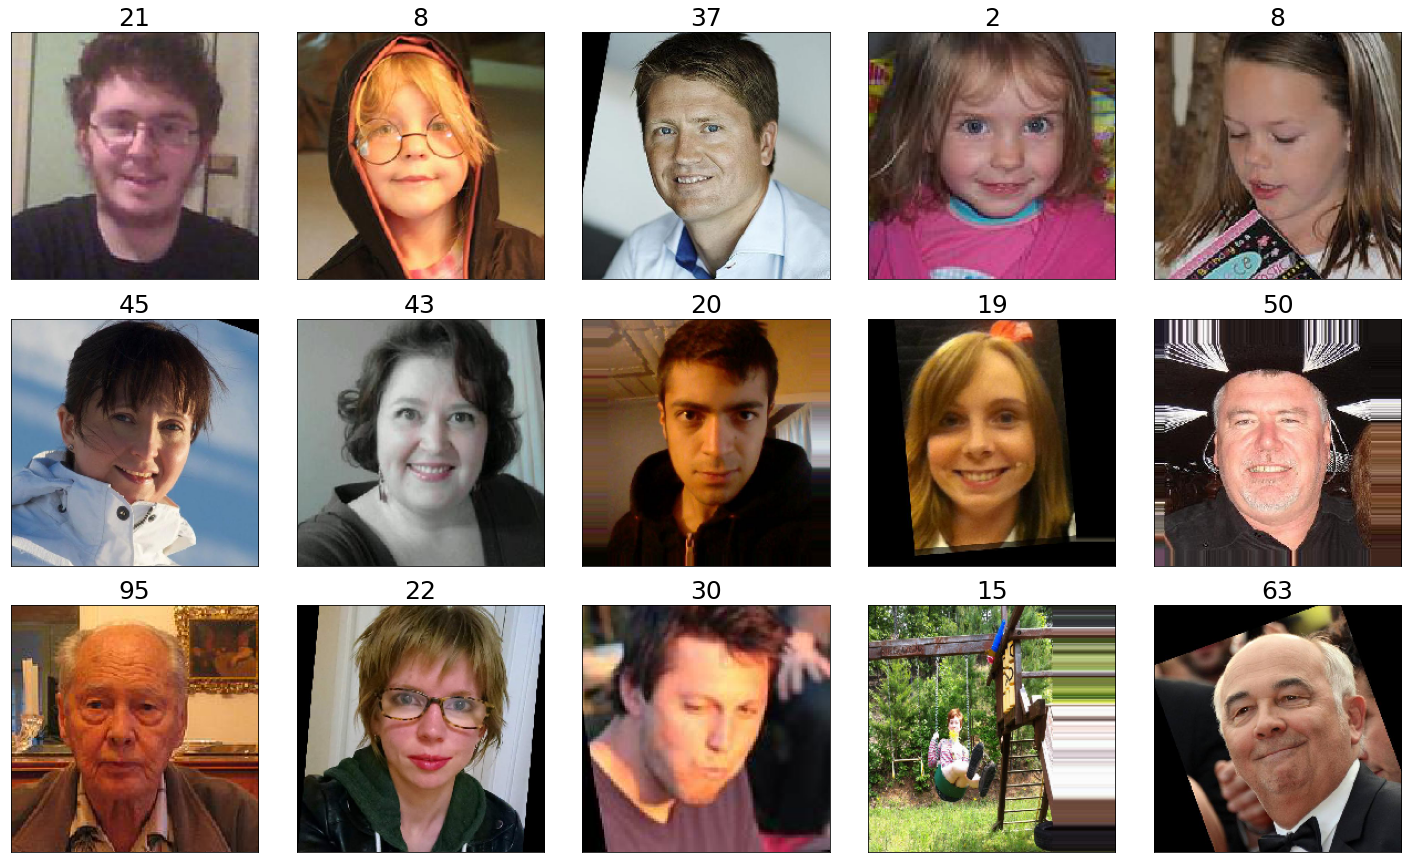

In [12]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(20,20))
for i in range(15):
    fig.add_subplot(5, 5, i+1)
    plt.imshow(features[i])
    plt.title(target[i],fontsize=25)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    

**Вывод:**  

- Судя по наименованиям в данных не присутствуют дубликаты фотографий и пропуски с обозначением возраста. 

- Пик у возрастного распределения среди покупателей находится в районе 27 лет. Всплеск в начале графика может говорить о том, что родители берут детей с собой. В общем и целом распределение нормальное.

- В основной массе лица на фотографиях хорошо различимы. Из аномалий в данных встречаются фотографии: повернутые, в плохом разрешении, растянутые, с несколькими людьми, без людей, с предметами заслоняющими лица. 

## Обучение модели

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25,
                                 rescale=1./255,
                                 horizontal_flip=True
                                 )
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25,
                                 rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    OPTIMIZER = Adam(lr=0.0001)
    model.compile(optimizer=OPTIMIZER,
                  loss='mean_squared_error',
                  metrics=['mae'])


    return model

def train_model(model, train_data,
                test_data,
                batch_size=None,
                epochs=5,
                steps_per_epoch=None,
                validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model


```

**Результат обучения**
Epoch 1/5
356/356 - 66s - loss: 228.8438 - mae: 10.8743 - val_loss: 583.3090 - val_mae: 18.9863  

Epoch 2/5
356/356 - 43s - loss: 86.3532 - mae: 7.0262 - val_loss: 138.5939 - val_mae: 8.8654  

Epoch 3/5
356/356 - 43s - loss: 59.2894 - mae: 5.8578 - val_loss: 78.0477 - val_mae: 6.5240  

Epoch 4/5
356/356 - 43s - loss: 40.1029 - mae: 4.8483 - val_loss: 76.4394 - val_mae: 6.6732  

Epoch 5/5
356/356 - 43s - loss: 33.4780 - mae: 4.3987 - val_loss: 75.1122 - val_mae: 6.5495  

**Итог:**  
119/119 - 10s - loss: 75.1122 - mae: 6.5495
**Test MAE: 6.5495**



## Анализ обученной модели

**Вывод:**  
Для решения поставленной задачи по определение возраста покупателей была до обучена на наших данных сеть ResNet50.
Обучение было остановлено на результате в MAE: 6.5495 поскольку это соответствовало требования по максимально допустимой погрешности MAE: 7.  Данный результат уже позволяет разбивать покупателей на категории, но не достаточен, чтобы корректно оценивать порог для продажи алкоголя. Увеличение базы фотографий, дополнительные мощности и время позволят значительно увеличить точность.